## Predict historical prices of Brent Oil, Crude Oil WTI, Natural Gas, Heating Oil from 2000-2022 with Fedot.Industrial

Dataset published on Kaggle3 consists of historical prices of Brent Oil, CrudeOil WTI, Natural Gas, and Heating Oil from 2000 to 2022. This sample of DailyOilGasPrices was created by using 30 consecutive business days of **Crude Oil WTI close prices** and **traded volumes** as **predictors** and the **average natural gas close** price during each 30-day time frame as the **target** variable. The final dataset has 191 2-dimensional time series of length 30, of which 70% were randomly sampled as training data and the remaining 30% as testing data. This type of model could help companies and governments to better analyse and predict economic situations and correlations regarding oil and natural gas.
Link to the dataset - https://www.kaggl.com/datasets/prasertk/historical-daily-oil-and-natural-gas-prices

In [1]:
import pandas as pd
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(train_data, api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

In [3]:
from datasets import load_dataset
dataset_name = 'fred_md'
horizon = 12
metric_names = ('smape', 'rmse', 'median_absolute_error')
train_data = load_dataset('monash_tsf', 'fred_md')
forecasting_metrics = ('smape', 'rmse')
params = dict(problem='ts_forecasting',
                             metric='rmse',
                             timeout=15,
                             pop_size = 10,
                             with_tuning = False,
                             task_params={'forecast_length': horizon},
                             industrial_strategy='forecasting_assumptions',
                             n_jobs=2,
                             logging_level=40)

2024-04-16 17:16:54,982 - PyTorch version 1.12.1+cu113 available.


Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
df_pandas = train_data['train'].to_pandas()
id_list = df_pandas['item_id'].values.tolist()
ts_list = [df_pandas[df_pandas['item_id']==id]['target'].values[0] for id in id_list]

In [5]:
train_data = ts_list[0]
target = train_data[-horizon:].flatten()
input_data = (train_data,target)

Lets check our data.

Lets visualise our predictors.

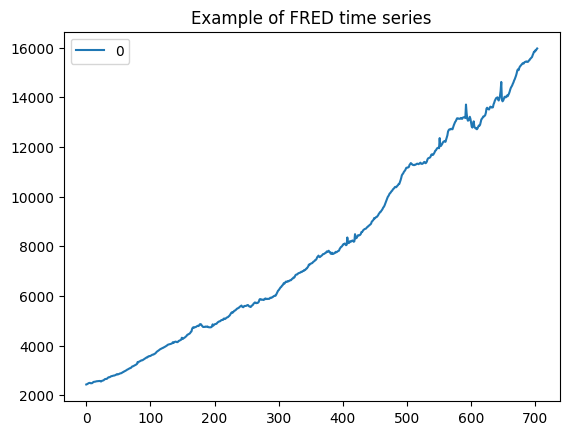

In [6]:
from matplotlib import pyplot as plt
pd.DataFrame(train_data).plot(title='Example of FRED time series')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [7]:
industrial_model =  evaluate_loop(train_data = input_data, api_params=params, finetune=True)

2024-04-16 17:16:59,719 - Initialising experiment setup
2024-04-16 17:16:59,828 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-04-16 17:16:59,829 - DataSourceSplitter - Hold out validation is applied.
2024-04-16 17:16:59,830 - SequentialTuner - Hyperparameters optimization start: estimation of metric for initial graph
2024-04-16 17:17:00,271 - SequentialTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ar, eigen_basis]}
ar - {'lag_1': 7, 'lag_2': 12}
eigen_basis - {'low_rank_approximation': False, 'rank_regularization': 'explained_dispersion'} 
Initial metric: [249.69]
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]2024-04-16 17:17:00,278 - build_posterior_wrapper took 0.001024 seconds
2024-04-16 17:17:00,279 - TPE using 0 trials
  1%|          | 1/100 [00:00<01:02,  1.58trial/s, best loss: 249.6899357167679]2024-04-16 17:17:00,913 - build_posterior_wrapper took 0.000997 seconds
2024-04-16 17:17:00,914 - TPE using 1/1 trials with best loss 249

[I 2024-04-16 17:19:26,234] A new study created in memory with name: no-name-df602a38-db92-442b-a82d-87aa52651b08


  0%|          | 0/200 [00:00<?, ?it/s]

2024-04-16 17:19:26,288 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 184 to 177.
2024-04-16 17:19:26,318 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 200 to 177.
2024-04-16 17:19:26,324 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 334 to 177.
2024-04-16 17:19:26,337 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 593 to 177.
2024-04-16 17:19:26,341 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 669 to 177.
2024-04-16 17:19:26,362 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 227 to 177.
2024-04-16 17:19:26,366 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 705 to 177.
2024-04-16 17:19:26,386 - AutoRegImplementation - Warning: lag of AutoRegImplementation was changed from 334 to 177.
2024-04-16 17:19:26,397 - AutoRegImplementation - Warning: lag o

In [8]:
labels = industrial_model.predict(train_data)
metrics = industrial_model.get_metrics(target=target,
                                         metric_names=metric_names)

In [9]:
metrics

,rmse,median_absolute_error,smape
0,61.109,59.41,0.34


## AutoML approach

In [10]:
industrial_auto_model = evaluate_loop(train_data=input_data, api_params=params, finetune=False)

2024-04-16 17:19:52,536 - Initialising experiment setup
2024-04-16 17:19:52,537 - Initialising Industrial Repository
2024-04-16 17:19:52,538 - Initialising Dask Server
Creating Dask Server
2024-04-16 17:19:53,023 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-16 17:19:53,053 - State start
2024-04-16 17:19:53,180 -   Scheduler at: inproc://10.64.4.32/16652/1
2024-04-16 17:19:53,180 -   dashboard at:  http://10.64.4.32:56716/status
2024-04-16 17:19:53,181 - Registering Worker plugin shuffle
2024-04-16 17:19:53,321 -       Start worker at: inproc://10.64.4.32/16652/4
2024-04-16 17:19:53,322 -          Listening to:           inproc10.64.4.32
2024-04-16 17:19:53,322 -           Worker name:                          0
2024-04-16 17:19:53,323 -          dashboard at:           10.64.4.32:56717
2024-04-16 17:19:53,324 - Waiting to connect to: inproc://10.64.4.32/16652/1
2024-04-16 17:19:53,324 - ------------

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-16 17:19:53,500 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 72
2024-04-16 17:19:53,725 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-16 17:19:55,860 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:19:57,759 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 126
2024-04-16 17:19:57,971 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2024-04-16 17:20:00,417 - IndustrialDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.
2024-04-16 17:20:01,183 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:20:02,

Generations:   0%|          | 1/10000 [00:10<30:25:45, 10.96s/gen]

2024-04-16 17:20:08,500 - IndustrialDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2024-04-16 17:20:10,006 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [00:16<21:37:34,  7.79s/gen]

2024-04-16 17:20:15,026 - IndustrialDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2024-04-16 17:20:19,035 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2024-04-16 17:20:19,563 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [00:26<23:52:49,  8.60s/gen]

2024-04-16 17:20:27,193 - IndustrialDispatcher - 23 individuals out of 23 in previous population were evaluated successfully.
2024-04-16 17:20:33,635 - IndustrialDispatcher - 19 individuals out of 19 in previous population were evaluated successfully.
2024-04-16 17:20:35,848 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:20:36,533 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:20:36,753 - IndustrialDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2024-04-16 17:20:36,795 - IndustrialDispatcher - 52 individuals out of 52 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [00:43<33:19:21, 12.00s/gen]

2024-04-16 17:20:47,033 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:20:47,460 - IndustrialDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2024-04-16 17:20:54,366 - IndustrialDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [01:00<38:56:43, 14.03s/gen]

2024-04-16 17:21:07,216 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:21:08,099 - IndustrialDispatcher - 47 individuals out of 47 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [01:14<38:39:11, 13.92s/gen]

2024-04-16 17:21:13,880 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:21:18,621 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:21:19,293 - IndustrialDispatcher - 34 individuals out of 34 in previous population were evaluated successfully.
2024-04-16 17:21:25,436 - IndustrialDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


Generations:   0%|          | 7/10000 [01:31<41:45:12, 15.04s/gen]

2024-04-16 17:21:32,766 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:21:34,974 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:21:37,246 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:21:37,481 - IndustrialDispatcher - 35 individuals out of 35 in previous population were evaluated successfully.
2024-04-16 17:21:39,874 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:21:40,586 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:21:42,503 - SparseLaggedTransformationImplementation - Window size of lagged transfo

Generations:   0%|          | 8/10000 [01:51<45:25:18, 16.36s/gen]

2024-04-16 17:21:48,662 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:21:50,115 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:21:51,720 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:21:52,892 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:21:55,834 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:21:56,319 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:21:57,003 - IndustrialDispatcher - 38 individuals out

Generations:   0%|          | 9/10000 [02:08<46:19:32, 16.69s/gen]

2024-04-16 17:22:04,767 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:22:05,231 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:09,358 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:11,818 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:22:12,930 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:22:13,612 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:22:13,843 - IndustrialDispatcher - 40 individuals out 

Generations:   0%|          | 10/10000 [02:23<45:02:00, 16.23s/gen]

2024-04-16 17:22:20,939 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:22:21,396 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:22:22,268 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:22:25,298 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:25,533 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:26,232 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:22:26,498 - SparseLaggedTransformationImplementation - 

Generations:   0%|          | 11/10000 [02:38<43:30:23, 15.68s/gen]

2024-04-16 17:22:34,441 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:35,126 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:22:35,567 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:22:35,805 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:22:36,488 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:22:36,942 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:22:37,194 - SparseLaggedTransformationImplementation -

Generations:   0%|          | 12/10000 [02:53<43:15:24, 15.59s/gen]

2024-04-16 17:22:49,579 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:22:49,819 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:22:50,049 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:22:50,718 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:22:51,404 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:22:53,912 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:22:54,352 - SparseLaggedTransformationImplementation -

Generations:   0%|          | 13/10000 [03:09<43:48:39, 15.79s/gen]

2024-04-16 17:23:06,251 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:07,713 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:08,648 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:23:08,885 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:23:09,116 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:11,139 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:11,382 - SparseLaggedTransformationImplementation -

Generations:   0%|          | 14/10000 [03:25<43:32:56, 15.70s/gen]

2024-04-16 17:23:22,260 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:22,735 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:23:23,229 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:23:23,916 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:24,798 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:23:26,010 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:27,060 - SparseLaggedTransformationImplementation 

Generations:   0%|          | 15/10000 [03:41<43:44:35, 15.77s/gen]

2024-04-16 17:23:37,624 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:23:38,974 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:39,435 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:23:39,883 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:23:41,224 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:41,459 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:23:42,122 - SparseLaggedTransformationImplementation 

Generations:   0%|          | 16/10000 [03:56<43:14:26, 15.59s/gen]

2024-04-16 17:23:52,919 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:53,158 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:53,885 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:54,799 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:23:55,573 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:23:55,811 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:23:56,378 - SparseLaggedTransformationImplementation

Generations:   0%|          | 17/10000 [04:12<43:28:09, 15.68s/gen]

2024-04-16 17:24:10,096 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:24:10,639 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:11,092 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:24:12,229 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:12,906 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:13,139 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:13,380 - SparseLaggedTransformationImplementation - 

Generations:   0%|          | 18/10000 [04:27<42:41:23, 15.40s/gen]

2024-04-16 17:24:23,930 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:24:24,161 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:24:25,106 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:24:26,026 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:24:26,920 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:27,380 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:27,818 - SparseLaggedTransformationImplementation -

Generations:   0%|          | 19/10000 [04:42<42:33:42, 15.35s/gen]

2024-04-16 17:24:41,449 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:24:41,917 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:24:43,264 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:43,496 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:24:44,377 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:24:45,566 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:24:47,830 - IndustrialDispatcher - 42 individuals out o

Generations:   0%|          | 20/10000 [04:56<41:47:16, 15.07s/gen]

2024-04-16 17:24:50,364 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 20/10000 [04:56<41:09:01, 14.84s/gen]


2024-04-16 17:24:50,502 - ApiComposer - Model generation finished
2024-04-16 17:24:50,508 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 90
2024-04-16 17:24:50,526 - FEDOT logger - Final pipeline was fitted
2024-04-16 17:24:50,528 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ridge, sparse_lagged]}
ridge - {}
sparse_lagged - {'window_size': 0.0, 'n_components': 0.1180416410888609, 'sparse_transform': True, 'use_svd': False}
2024-04-16 17:24:50,530 - MemoryAnalytics - Memory consumption for finish in main session: current 4.2 MiB, max: 5.6 MiB
2024-04-16 17:24:50,692 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 1.1 MiB
2024-04-16 17:24:50,693 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2024-04-16 17:24:50,694 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initi

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-16 17:24:51,483 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-16 17:25:01,465 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2024-04-16 17:25:08,176 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2024-04-16 17:25:08,927 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


Generations:   0%|          | 1/10000 [00:18<50:32:22, 18.20s/gen]

2024-04-16 17:25:15,839 - IndustrialDispatcher - 8 individuals out of 9 in previous population were evaluated successfully.
2024-04-16 17:25:24,246 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [00:33<45:50:09, 16.50s/gen]

2024-04-16 17:25:37,621 - IndustrialDispatcher - 15 individuals out of 16 in previous population were evaluated successfully.
2024-04-16 17:25:49,313 - IndustrialDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [00:58<56:41:43, 20.42s/gen]

2024-04-16 17:26:12,238 - IndustrialDispatcher - 29 individuals out of 29 in previous population were evaluated successfully.
2024-04-16 17:26:30,655 - IndustrialDispatcher - 25 individuals out of 25 in previous population were evaluated successfully.
2024-04-16 17:26:30,681 - IndustrialDispatcher - 53 individuals out of 53 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [01:39<79:38:50, 28.68s/gen]

2024-04-16 17:27:01,186 - IndustrialDispatcher - 41 individuals out of 42 in previous population were evaluated successfully.
2024-04-16 17:27:11,987 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [02:21<92:17:36, 33.24s/gen]

2024-04-16 17:27:43,932 - IndustrialDispatcher - 39 individuals out of 39 in previous population were evaluated successfully.
2024-04-16 17:27:53,441 - IndustrialDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [03:02<100:02:20, 36.04s/gen]

2024-04-16 17:28:23,773 - IndustrialDispatcher - 41 individuals out of 41 in previous population were evaluated successfully.
2024-04-16 17:28:33,851 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:   0%|          | 7/10000 [03:43<103:59:42, 37.46s/gen]

2024-04-16 17:29:06,861 - IndustrialDispatcher - 42 individuals out of 42 in previous population were evaluated successfully.
2024-04-16 17:29:13,349 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:   0%|          | 8/10000 [04:22<105:47:07, 38.11s/gen]

2024-04-16 17:29:51,794 - IndustrialDispatcher - 44 individuals out of 46 in previous population were evaluated successfully.
2024-04-16 17:30:17,345 - IndustrialDispatcher - 49 individuals out of 49 in previous population were evaluated successfully.


Generations:   0%|          | 9/10000 [05:26<128:12:37, 46.20s/gen]

2024-04-16 17:30:17,443 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 9/10000 [05:26<100:44:42, 36.30s/gen]


2024-04-16 17:30:17,578 - ApiComposer - Model generation finished
2024-04-16 17:30:17,637 - FEDOT logger - Final pipeline was fitted
2024-04-16 17:30:17,640 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, eigen_basis]}
ar - {'lag_1': 2.453974652806001, 'lag_2': 107.35271359053489}
eigen_basis - {'window_size': 10, 'stride': 2, 'rank_regularization': 'explained_dispersion'}
2024-04-16 17:30:17,640 - MemoryAnalytics - Memory consumption for finish in main session: current 3.3 MiB, max: 7.5 MiB
2024-04-16 17:30:17,695 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 54
2024-04-16 17:30:24,374 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 1.1 MiB, max: 10.9 MiB
2024-04-16 17:30:24,375 - ApiComposer - Initial pipeline was fitted in 6.7 sec.
2024-04-16 17:30:24,377 - AssumptionsHandler - Preset was changed to fast_train due to fit time estim

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-16 17:30:24,428 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 36
2024-04-16 17:30:27,069 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-16 17:30:31,691 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 126
2024-04-16 17:30:40,802 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 108
2024-04-16 17:30:51,427 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2024-04-16 17:31:12,637 - IndustrialDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2024-04-16 17:31:17,295 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 1/10000 [00:52<146:52:45, 52.88s/gen]

2024-04-16 17:31:26,602 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2024-04-16 17:31:42,022 - IndustrialDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2024-04-16 17:31:45,790 - IndustrialDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2024-04-16 17:31:48,190 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [01:23<110:56:58, 39.95s/gen]

2024-04-16 17:32:07,771 - IndustrialDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2024-04-16 17:32:28,677 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2024-04-16 17:32:31,049 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [02:06<114:37:44, 41.28s/gen]

2024-04-16 17:32:56,478 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:33:04,363 - IndustrialDispatcher - 25 individuals out of 25 in previous population were evaluated successfully.
2024-04-16 17:33:13,188 - IndustrialDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.
2024-04-16 17:33:13,202 - IndustrialDispatcher - 29 individuals out of 29 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [02:48<115:34:00, 41.62s/gen]

2024-04-16 17:33:38,241 - IndustrialDispatcher - 23 individuals out of 23 in previous population were evaluated successfully.
2024-04-16 17:33:41,893 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [03:17<102:37:08, 36.96s/gen]

2024-04-16 17:33:57,012 - IndustrialDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.
2024-04-16 17:34:19,319 - IndustrialDispatcher - 19 individuals out of 19 in previous population were evaluated successfully.
2024-04-16 17:34:43,695 - IndustrialDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [04:19<126:04:03, 45.41s/gen]

2024-04-16 17:34:56,907 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 72
2024-04-16 17:34:57,471 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 54
2024-04-16 17:35:09,349 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 36
2024-04-16 17:35:24,569 - IndustrialDispatcher - 33 individuals out of 37 in previous population were evaluated successfully.


Generations:   0%|          | 7/10000 [05:43<161:27:20, 58.16s/gen]

2024-04-16 17:36:08,262 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 7/10000 [05:43<136:21:03, 49.12s/gen]


2024-04-16 17:36:08,413 - ApiComposer - Model generation finished
2024-04-16 17:36:08,420 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 108
2024-04-16 17:36:09,629 - FEDOT logger - Final pipeline was fitted
2024-04-16 17:36:09,630 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [cgru, sparse_lagged]}
cgru - {'hidden_size': 158.30407610790505, 'learning_rate': 0.000543080558248984, 'cnn1_kernel_size': 8, 'cnn1_output_size': 8, 'cnn2_kernel_size': 5, 'cnn2_output_size': 16, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd', 'loss': 'mse'}
sparse_lagged - {'window_size': 0.0, 'n_components': 0.40833166600342236, 'sparse_transform': True, 'use_svd': False}
2024-04-16 17:36:09,633 - MemoryAnalytics - Memory consumption for finish in main session: current 2.6 MiB, max: 12.0 MiB


In [11]:
auto_labels = industrial_auto_model.predict(train_data)

2024-04-16 17:36:09,654 - FEDOT logger - Predictions was saved in current directory.
2024-04-16 17:36:09,672 - FEDOT logger - Predictions was saved in current directory.
2024-04-16 17:36:09,692 - FEDOT logger - Predictions was saved in current directory.


In [12]:
auto_labels

{'lagged_ridge': array([3441.2068, 3444.8994, 3467.576 , 3472.65  , 3487.9539, 3492.53  ,
        3500.8967, 3514.6497, 3526.1355, 3528.9202, 3546.5327, 3558.0042],
       dtype=float32),
 'eigen_ar': array([15590.29537753, 15648.56481268, 15660.39152143, 15706.55375476,
        15721.38771949, 15760.6159579 , 15781.05085021, 15808.97149877,
        15837.48643811, 15868.08606562, 15899.40044425, 15931.8059312 ]),
 'cgru': array([4030163.2, 4209092. , 4220507. , 4121936.5, 4162513.5, 4084354.2,
        4032436. , 4082034.5, 3989331.8, 3930705.5, 4132583.2, 3999557.2],
       dtype=float32)}

In [13]:
auto_metrics = {}
for forecat_model, predict in auto_labels.items():
    industrial_auto_model.predicted_labels = predict

    current_metric = industrial_auto_model.get_metrics(target=target,
                                            metric_names=metric_names)
    auto_metrics.update({forecat_model:current_metric})

In [16]:
auto_metrics['eigen_ar']

,rmse,median_absolute_error,smape
0,49.416,38.581,0.265


In [17]:
import numpy as np
border = 100
baseline = labels
ridge = auto_labels['lagged_ridge']
eigen = auto_labels['eigen_ar']
cgru = auto_labels['cgru']
plt.close()
real_values = train_data
if len(real_values) > border:
    real_values = real_values[-border:]
indicies = np.arange(real_values.shape[0])

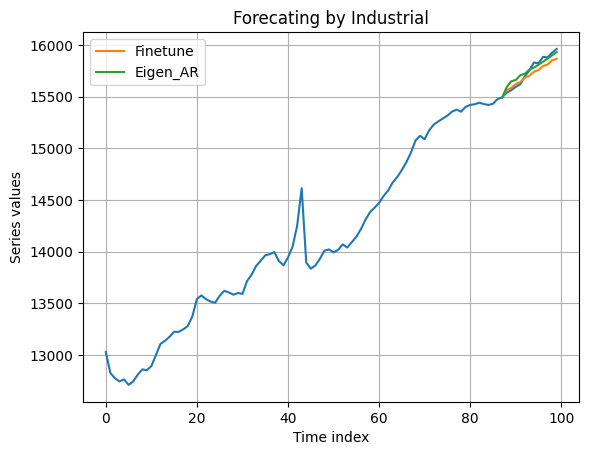

In [21]:
plt.xlabel('Time index')
plt.ylabel('Series values')
plt.title('Forecating by Industrial')
plt.plot(real_values)

real_last_value = real_values[-horizon- 1]
plt.plot(indicies[-horizon- 1:],
         np.insert(baseline, 0, real_last_value), label='Finetune')
plt.plot(indicies[-horizon- 1:],
         np.insert(eigen, 0, real_last_value), label='Eigen_AR')

plt.grid()
plt.legend()

## Compare with State of Art (SOTA) models